In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [99]:
start_date = '2021-01-01'
end_date = '2023-12-31'

In [100]:
stocks = ['TSLA', 'NVDA', 'VOO']

In [101]:
data = yf.download(stocks, start=start_date, end=end_date)
prices = data['Adj Close']

[*********************100%***********************]  3 of 3 completed


In [102]:
moving_averages = prices.rolling(window=200, min_periods=1).mean()

In [103]:
def buy_the_dip(prices, moving_averages, drop_threshold=0.10, profit_threshold=0.05, stop_loss_threshold=0.20):
    positions = {stock: {'holding': False, 'buy_price': 0} for stock in prices.columns}
    cash = 100000  # Starting capital
    portfolio_value = []
    holdings = {stock: 0 for stock in prices.columns}
    dates = prices.index

    for date in dates:
        for stock in prices.columns:
            price = prices.loc[date, stock]
            ma = moving_averages.loc[date, stock]
            if pd.notna(price) and pd.notna(ma):
                drop = (ma - price) / ma
            
                if not positions[stock]['holding'] and drop >= drop_threshold:
                    # Buy signal
                    amount_to_invest = cash * 0.2
                    shares_to_buy = amount_to_invest // price
                    if shares_to_buy > 0:
                        cash -= shares_to_buy * price
                        holdings[stock] += shares_to_buy
                        positions[stock]['holding'] = True
                        positions[stock]['buy_price'] = price
                        print(f"{date.date()}: Bought {shares_to_buy} shares of {stock} at ${price:.2f}")

                elif positions[stock]['holding']:
                    profit = (price - positions[stock]['buy_price']) / positions[stock]['buy_price']
                    if profit >= profit_threshold:
                        # Sell signal
                        shares_to_sell = holdings[stock]
                        cash += shares_to_sell * price
                        holdings[stock] = 0
                        positions[stock]['holding'] = False
                        print(f"{date.date()}: Sold {shares_to_sell} shares of {stock} at ${price:.2f}")
                    elif profit <= -stop_loss_threshold:
                        # Sell signal (Stop Loss)
                        shares_to_sell = holdings[stock]
                        cash += shares_to_sell * price
                        holdings[stock] = 0
                        positions[stock]['holding'] = False
                        print(f"{date.date()}: Stop-loss triggered. Sold {shares_to_sell} shares of {stock} at ${price:.2f}")

        # Calculate total portfolio value
        total_value = cash + sum(holdings[stock] * prices.loc[date, stock] for stock in holdings)
        portfolio_value.append(total_value)

    # Create a DataFrame for portfolio value over time
    portfolio_df = pd.DataFrame({'Date': dates, 'Portfolio Value': portfolio_value})
    portfolio_df.set_index('Date', inplace=True)
    return portfolio_df

In [104]:
portfolio_df = buy_the_dip(
    prices,
    moving_averages,
    drop_threshold=0.05,
    profit_threshold=0.10,
    stop_loss_threshold=1.0
)

2021-02-18: Bought 76.0 shares of TSLA at $262.46
2021-03-03: Bought 1253.0 shares of NVDA at $12.77
2021-04-07: Sold 1253.0 shares of NVDA at $14.11
2021-10-18: Sold 76.0 shares of TSLA at $290.04
2022-02-23: Bought 81.0 shares of TSLA at $254.68
2022-02-28: Sold 81.0 shares of TSLA at $290.14
2022-03-07: Bought 1000.0 shares of NVDA at $21.32
2022-03-07: Bought 46.0 shares of VOO at $369.59
2022-03-11: Bought 51.0 shares of TSLA at $265.12
2022-03-16: Sold 1000.0 shares of NVDA at $24.46
2022-03-18: Sold 51.0 shares of TSLA at $301.80
2022-03-29: Sold 46.0 shares of VOO at $408.03
2022-04-08: Bought 982.0 shares of NVDA at $23.09
2022-04-26: Bought 49.0 shares of VOO at $367.88
2022-05-09: Bought 55.0 shares of TSLA at $262.37
2022-07-29: Sold 55.0 shares of TSLA at $297.15
2022-08-05: Bought 51.0 shares of TSLA at $288.17
2023-03-16: Sold 982.0 shares of NVDA at $25.53
2023-07-13: Sold 49.0 shares of VOO at $405.81


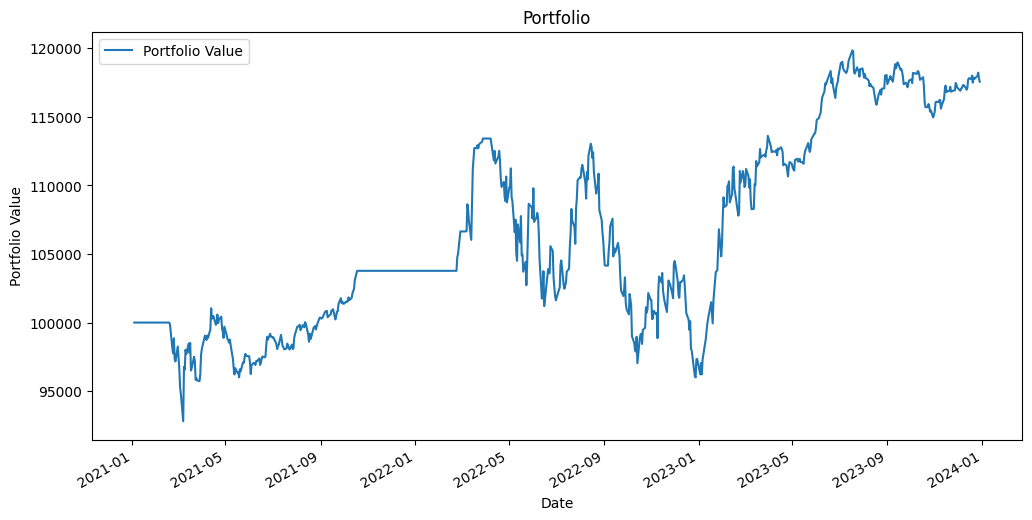

In [105]:
portfolio_df.plot(figsize=(12, 6))
plt.title('Portfolio')
plt.ylabel('Portfolio Value')
plt.show()

In [106]:
initial_value = portfolio_df['Portfolio Value'].iloc[0]
final_value = portfolio_df['Portfolio Value'].iloc[-1]
total_return = (final_value - initial_value) / initial_value * 100
print(f"Total Return: {total_return:.2f}%")

Total Return: 17.57%
